<a href="https://colab.research.google.com/github/aish0606/DeepLearning/blob/main/CNN/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# https://cs231n.github.io/convolutional-networks/
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [20]:
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed 
mean_gray = 0.1307
stddev_gray = 0.3081

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) 
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray, ), (stddev_gray,))])

# Load the datasets
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)
test_dataset = datasets.MNIST(root='./data',
                               train=False,
                               transform=transform)

Label of Image is 5


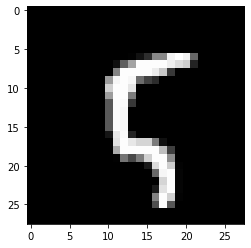

In [21]:
# To visualize an image
import matplotlib.pyplot as plt
random_img = train_dataset[100][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28, 28), cmap='gray')
print('Label of Image is {}'.format(train_dataset[100][1]))

In [34]:
batch_size = 200
train_load = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
test_load = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

In [35]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 300 batches in the train loader
There are 50 batches in the testloader


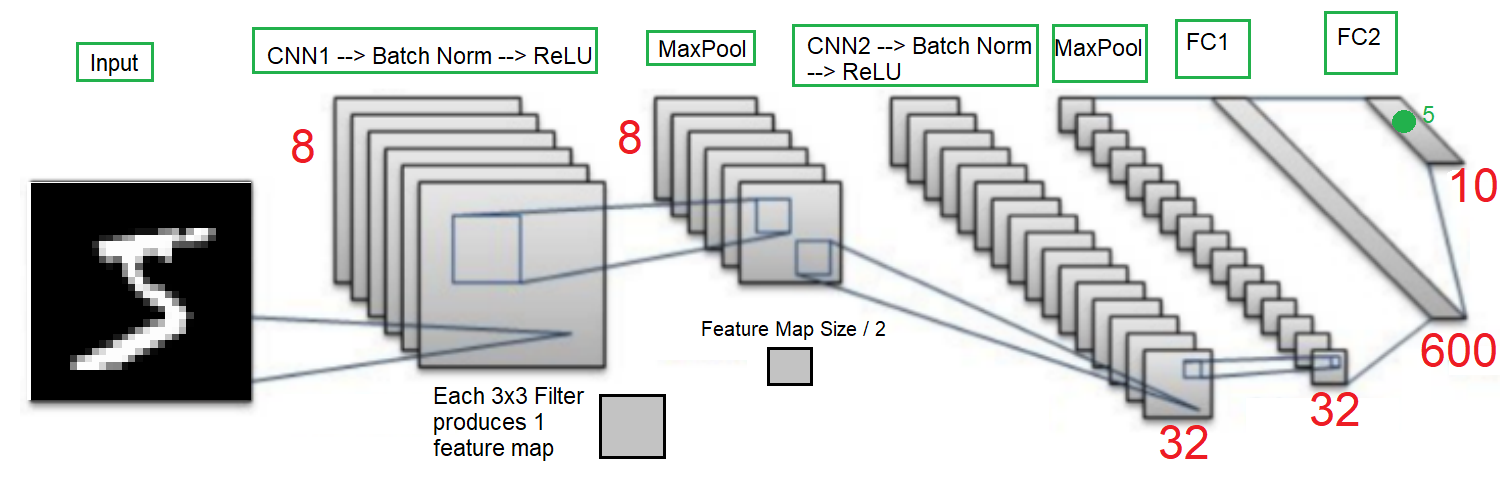

In [36]:
# Create the Model class
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    #Same Padding = [(filter size - 1) / 2] --> (3-1)/2 = 1
    #(Same Padding--> input size = output size)
    # Here we want to keep the size of the image same. Therefore stride = 1
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    #The output size of each of the 8 feature maps is 
    #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
    #Batch normalization
    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    #After max pooling, the output of each feature map is now 28/2 = 14
    # Same Padding = 5-1/2 = 2
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    # Output size of each 32 feature map = 14 - 5 + 2(2) / 1 +1 =14 (Remains Equal)
    self.batchnorm2 = nn.BatchNorm2d(num_features=32)
    #After max pooling, the output of each feature map is 14/2 = 7
    #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568    
    self.fc1 = nn.Linear(in_features=1568, out_features=600)
    # Applying dropout b/w NN is good
    self.dropout = nn.Dropout(p=0.5) # Half of the neurons will be dropped
    self.fc2 = nn.Linear(in_features=600, out_features=10) # As o/p are 10 from 0-9
  
  def forward(self, x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool(out)
    #Now we have to flatten the output. Now we will apply the feed forward neural network
    #It will take the shape (batch_size, 1568) = (100, 1568)
    out = out.view(-1, 1568)
    #Then we forward through our fully connected layer     
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    return out


In [37]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [38]:
#Understand what's happening
iteration = 0
correct = 0

for i,(inputs,labels) in enumerate (train_load):

    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted Shape",predicted.shape)
    print("Predicted Tensor:")
    print(predicted)
    correct += (predicted == labels).sum()
    break

For one iteration, this is what happens:
Input Shape: torch.Size([200, 1, 28, 28])
Labels Shape: torch.Size([200])
Outputs Shape torch.Size([200, 10])
Predicted Shape torch.Size([200])
Predicted Tensor:
tensor([0, 4, 1, 3, 2, 4, 9, 1, 0, 1, 4, 4, 9, 6, 5, 0, 3, 0, 3, 8, 4, 8, 2, 1,
        6, 1, 0, 5, 6, 1, 4, 9, 1, 6, 0, 1, 9, 9, 1, 0, 1, 9, 1, 0, 1, 0, 6, 1,
        8, 5, 6, 9, 1, 1, 0, 1, 4, 3, 9, 1, 6, 1, 5, 4, 6, 1, 8, 9, 1, 5, 9, 4,
        4, 2, 8, 3, 2, 1, 9, 0, 9, 5, 0, 4, 4, 0, 1, 0, 0, 1, 1, 4, 6, 1, 0, 4,
        9, 1, 4, 4, 8, 4, 1, 0, 9, 6, 6, 8, 1, 1, 4, 6, 4, 1, 0, 0, 1, 9, 1, 3,
        4, 0, 8, 5, 5, 6, 1, 8, 8, 1, 1, 6, 2, 1, 0, 5, 4, 6, 6, 4, 2, 6, 1, 9,
        8, 3, 5, 5, 3, 9, 0, 4, 6, 1, 4, 9, 4, 4, 0, 0, 5, 5, 5, 1, 9, 9, 0, 9,
        9, 1, 1, 9, 0, 4, 1, 4, 2, 3, 1, 1, 0, 8, 9, 5, 4, 9, 4, 1, 4, 0, 8, 8,
        0, 9, 4, 8, 1, 4, 8, 1], device='cuda:0')


In [39]:
print(labels.dtype)
outputs.dtype

torch.int64


torch.float32

In [1]:
"""# Training the CNN
# See the error
epochs = 10
#Define the lists to store the results of loss and accuracy
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(epochs):
    correct = 0
    iteration = 0
    iter_loss = 0.00
    model.train()    # Put the network into training model
    for i, (inputs, labels) in enumerate(train_load):
        if CUDA:
            inputs = inputs.cuda()
            labels = inputs.cuda()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Record the correct predictions for training data         
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iteration += 1

    train_loss.append(iter_loss / len(iteration)) # train_load
    train_accuracy.append(correct / len(train_dataset))

    # Testing Phase
    test_loss = 0.00
    iteration = 0
    correct = 0
    for i, (inputs, labels) in enumerate(test_load):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss

        # Record the correct predictions for training data         
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iteration += 1

    test_loss.append(test_loss / len(iteration)) # train_load
    test_accuracy.append(correct / len(test_dataset))            


    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))
"""

"# Training the CNN\n# See the error\nepochs = 10\n#Define the lists to store the results of loss and accuracy\ntrain_loss = []\ntrain_accuracy = []\ntest_loss = []\ntest_accuracy = []\nfor epoch in range(epochs):\n    correct = 0\n    iteration = 0\n    iter_loss = 0.00\n    model.train()    # Put the network into training model\n    for i, (inputs, labels) in enumerate(train_load):\n        if CUDA:\n            inputs = inputs.cuda()\n            labels = inputs.cuda()\n        outputs = model(inputs)\n        loss = loss_fn(outputs, labels)\n        iter_loss += loss\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        # Record the correct predictions for training data         \n        _, predicted = torch.max(outputs, 1)\n        correct += (predicted == labels).sum()\n        iteration += 1\n\n    train_loss.append(iter_loss / len(iteration)) # train_load\n    train_accuracy.append(correct / len(train_dataset))\n\n    # Testing Phase\n    te

In [40]:
#Training the CNN
num_epochs = 10

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()         # Accumulate the loss
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    testing_loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 1.461, Training Accuracy: 90.135, Testing Loss: 0.074, Testing Acc: 97.640
Epoch 2/10, Training Loss: 0.077, Training Accuracy: 97.697, Testing Loss: 0.048, Testing Acc: 98.480
Epoch 3/10, Training Loss: 0.057, Training Accuracy: 98.265, Testing Loss: 0.038, Testing Acc: 98.710
Epoch 4/10, Training Loss: 0.043, Training Accuracy: 98.607, Testing Loss: 0.040, Testing Acc: 98.700
Epoch 5/10, Training Loss: 0.039, Training Accuracy: 98.775, Testing Loss: 0.032, Testing Acc: 98.950
Epoch 6/10, Training Loss: 0.034, Training Accuracy: 98.868, Testing Loss: 0.031, Testing Acc: 99.020
Epoch 7/10, Training Loss: 0.033, Training Accuracy: 98.950, Testing Loss: 0.028, Testing Acc: 99.080
Epoch 8/10, Training Loss: 0.031, Training Accuracy: 98.992, Testing Loss: 0.036, Testing Acc: 98.910
Epoch 9/10, Training Loss: 0.032, Training Accuracy: 98.972, Testing Loss: 0.060, Testing Acc: 98.390
Epoch 10/10, Training Loss: 0.032, Training Accuracy: 98.977, Testing Loss: 0.043,

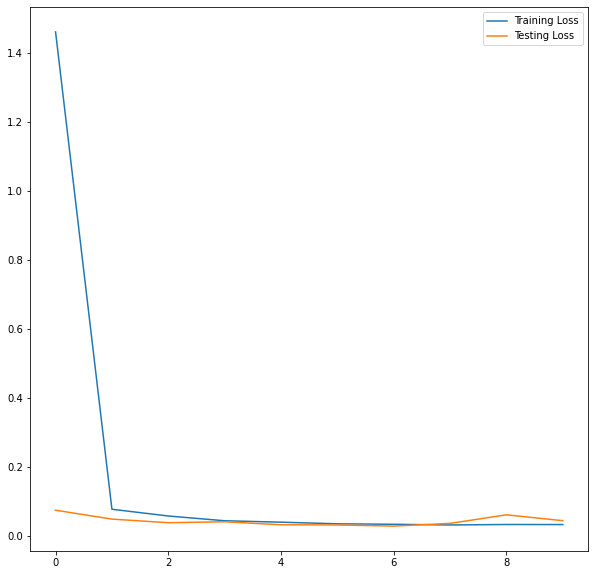

In [41]:
# Plotting Loss
f = plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

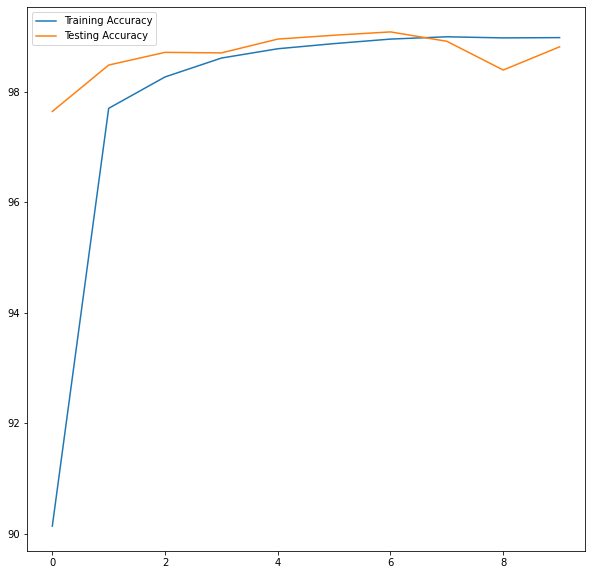

In [42]:
# Plotting Loss
f = plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [49]:
print(test_dataset[30][0].shape)
# When we pass an image in Pytorch NN it should be 4D --> ([batch_size, channels, rows, column])
# therefore we add the batch_size = 1
img = test_dataset[30][0].resize_((1,1,28,28))
label = test_dataset[30][1]

model.eval()
if CUDA:
  img = img.cuda()
  model = model.cuda()
output = model(img)
_, predicted = torch.max(output,1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

torch.Size([1, 28, 28])
Prediction is: 3
Actual is: 3
